## Load In Dependencies

In [ ]:
!pip install ipyleaflet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Note: Environment setup
Running this notebook requires an API key.

To use your API key locally, set the environment variable <i><b>PC_SDK_SUBSCRIPTION_KEY</i></b> or use <i><b>planetary_computer.settings.set_subscription_key(<YOUR API Key>)</i></b><br>
See <a href="https://planetarycomputer.microsoft.com/docs/concepts/sas/#when-an-account-is-needed">when an account is needed for more </a>, and <a href="https://planetarycomputer.microsoft.com/account/request">request</a> an account if needed.

In [ ]:
!pip install pystac
!pip install pystac_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install planetary_computer


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install "rich[jupyter]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install odc-stac

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Crop_Location_Data_20221201.csv to Crop_Location_Data_20221201 (1).csv


## Response Variable

Data is from a certain region in Vietnam for the year 2020. The data consists of  geo locations (Latitude and Longitude) with a tag specifying if the crop present in each geo location is rice or not.  

In [ ]:
crop_presence_data = pd.read_csv("Crop_Location_Data_20221201.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


## Predictor Variables

In [ ]:
pc.settings.set_subscription_key('41bceb117488421db87b00886641ef9d')

In [ ]:
import math

In [ ]:
def get_sentinel_data(latlong,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')

    box_size_deg = 0.0004 # Surrounding box in degrees, yields approximately 5x5 pixel region

    min_lon = float(latlong[1])-box_size_deg/2
    min_lat = float(latlong[0])-box_size_deg/2
    max_lon = float(latlong[1])+box_size_deg/2
    max_lat = float(latlong[0])+box_size_deg/2

    bbox_of_interest = (min_lon, min_lat, max_lon, max_lat)

    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )

    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest
    )

    items = list(search.get_all_items())

    bands_of_interest = assets

    resolution = 10  # meters per pixel
    scale = resolution / 111320.0 # degrees per pixel for crs=4326

    data = stac_load(items, bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest, crs="EPSG:4326",resolution=scale)

    mean = data.mean(dim=['latitude','longitude'])
    mean1 = mean.mean(dim = ['time'])

    vh = float([mean1.vh.values][0])
    vv = float([mean1.vv.values][0])

    # Calculate RVI
    dop = (vv / (vv + vh))
    m = 1 - dop
    rvi = (math.sqrt(dop))*((4*vh)/(vv + vh))

    return vh,vv,rvi


In [ ]:
## Function call to extract VV,VH Values
time_slice1 = "2021-01-01/2021-01-15"
time_slice2 = "2021-12-01/2022-04-30"
time_slice2 = "2021-12-01/2022-04-30"
assets = ['vh','vv']
vh_vv = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    vh_vv.append(get_sentinel_data(coordinates,time_slice1,assets))

vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv','rvi'])

100%|██████████| 600/600 [15:55<00:00,  1.59s/it]


In [ ]:
vh_vv_data.head()

,vh,vv,rvi
0,0.011432,0.194914,0.215377
1,0.009528,0.202875,0.175354
2,0.018935,0.169832,0.380575
3,0.012970,0.223264,0.213497
4,0.022346,0.197064,0.386082


In [ ]:
# Filter data using the Sentinel-2 SCL band classification

# scl=0 > No Data
# scl=1 > Saturated
# scl=3 > Cloud Shadows
# scl=6 > Water
# scl=8 > Cloud Medium Probability
# scl=9 > Cloud High Probability
# scl=10 > Thin Cirrus Cloud
# Create a colormap to display the SCL pixel classifications

scl_colormap = np.array(
    [
        [252,  40, 228, 255],  # 0  - NODATA - MAGENTA
        [255,   0,   4, 255],  # 1  - Saturated or Defective - RED
        [0  ,   0,   0, 255],  # 2  - Dark Areas - BLACK
        [97 ,  97,  97, 255],  # 3  - Cloud Shadow - DARK GREY
        [3  , 139,  80, 255],  # 4  - Vegetation - GREEN
        [192, 132,  12, 255],  # 5  - Bare Ground - BROWN
        [21 , 103, 141, 255],  # 6  - Water - BLUE
        [117,   0,  27, 255],  # 7  - Unclassified - MAROON
        [208, 208, 208, 255],  # 8  - Cloud - LIGHT GREY
        [244, 244, 244, 255],  # 9  - Definitely Cloud - WHITE
        [195, 231, 240, 255],  # 10 - Thin Cloud - LIGHT BLUE
        [222, 157, 204, 255],  # 11 - Snow or Ice - PINK
    ],
    dtype="uint8",
)

def colorize(data, colormap):
    return xr.DataArray(colormap[data.data], coords=data.coords, dims=(*data.dims, "band"))

In [ ]:
def get_sentinel2_data(latlong,time_slice,assets):
    '''
    Returns red, green, blue, nir, NDVI, EVI, NDWI values for a given latitude and longitude
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the red, green, blue, nir, NDVI, EVI, NDWI values have to be extracted
    assets - A list of bands to be extracted
    '''

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')

    box_size_deg = 0.10 # Surrounding box in degrees, yields approximately 5x5 pixel region



    min_lon = float(latlong[1])-box_size_deg/2
    min_lat = float(latlong[0])-box_size_deg/2
    max_lon = float(latlong[1])+box_size_deg/2
    max_lat = float(latlong[0])+box_size_deg/2
    bbox_of_interest = (min_lon, min_lat, max_lon, max_lat)

    time_of_interest = time_slice

    bands_of_interest = assets

    # Define the pixel resolution for the final product
    # Define the scale according to our selected crs, so we will use degrees
    resolution = 20  # meters per pixel
    scale = resolution / 111320.0 # degrees per pixel for CRS:4326

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )

    search = catalog.search(
        collections=["sentinel-2-l2a"], bbox=bbox_of_interest, datetime=time_of_interest
    )

    items = list(search.get_all_items())

    data = stac_load(
    items,
    bands=["red", "green", "blue", "nir", "SCL"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=pc.sign,
    bbox=bbox_of_interest
    )

    # Create a mask for no data, saturated data, clouds, cloud shadows, and water

    cloud_mask = \
    (data.SCL != 0) & \
    (data.SCL != 1) & \
    (data.SCL != 3) & \
    (data.SCL != 6) & \
    (data.SCL != 8) & \
    (data.SCL != 9) & \
    (data.SCL != 10)

    cleaned_data = data.where(cloud_mask).astype("uint16")

    mean_cleaned_data_loc = data.mean(dim=['latitude','longitude'])
    mean_cleaned_data_time = mean_cleaned_data_loc.median(dim = ['time'])

    red = float([mean_cleaned_data_time.red.values][0])
    green = float([mean_cleaned_data_time.green.values][0])
    blue = float([mean_cleaned_data_time.blue.values][0])
    nir = float([mean_cleaned_data_time.nir.values][0])

    # Calculate NDVI
    NDVI = ((nir - red) / (nir + red))

    # Calculate EVI
    EVI = 2.5 * ((nir - red) / (nir + (6 * red) - (7.5 * blue) + 1))

    # Calculate NDWI
    NDWI = ((green - nir) / (green + nir))



    return red, green, blue, nir, NDVI, EVI, NDWI


In [ ]:
import xarray as xr

In [ ]:
## Function call to extract red, green, blue, nir, NDVI, EVI, NDWI Values
time_slice1 = "2021-01-01/2021-01-08"
# time_slice2 = "2021-04-01/2021-04-10"
# time_slice3 = "2021-04-01/2021-04-10"

assets = ['red','green', 'blue', 'nir']
mar_bands_set = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    mar_bands_set.append(get_sentinel2_data(coordinates,time_slice1,assets))

mar_bands_set_data = pd.DataFrame(mar_bands_set,columns =['red','green', 'blue', 'nir', 'NDVI', 'EVI', 'NDWI'])

  0%|          | 0/600 [00:01<?, ?it/s]


NotImplementedError: ignored

## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [ ]:
def combine_two_datasets(dataset1,dataset2,dataset3):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined
    dataset2 - Dataset 2 to be combined
    dataset3 - Dataset 3 to be combined
    '''
    data = pd.concat([dataset1,dataset2, dataset3], axis=1)
    return data

In [ ]:
crop_data = combine_two_datasets(crop_presence_data, mar_bands_set_data, vh_vv_data)
crop_data.head()


,Latitude and Longitude,Class of Land,red,green,blue,nir,NDVI,EVI,NDWI,vh,vv,rvi
0,"(10.323727047081501, 105.2516346045924)",Rice,7292.765069,7926.548200,8698.562936,7295.185228,0.000166,-0.000426,0.041478,0.011432,0.194914,0.215377
1,"(10.322364360592521, 105.27843410554115)",Rice,7132.917177,7764.495189,8523.905037,7227.791845,0.006607,-0.017060,0.035799,0.009528,0.202875,0.175354
2,"(10.321455902933202, 105.25254306225168)",Rice,7311.049401,7948.416967,8723.558773,7320.318102,0.000633,-0.001627,0.041136,0.018935,0.169832,0.380575
3,"(10.324181275911162, 105.25118037576274)",Rice,7285.511695,7918.265336,8689.218664,7286.200781,0.000047,-0.000122,0.041571,0.012970,0.223264,0.213497
4,"(10.324635504740822, 105.27389181724476)",Rice,7187.133183,7819.849887,8583.824727,7259.681988,0.005022,-0.012960,0.037148,0.022346,0.197064,0.386082


SVD Stuff

compute the SVD of the standardized dataset

Choose the components that explains a significant portion of the variance in the data.

Keep only the sigma values you want

Reconstruct the dataset by multiplying the truncated U, S, and V matrices back together.

The resulting dataset will have reduced noise and only include the most important features that explain the most variance in the data


In [ ]:
#Compute SVD for two sperate matrices(rice and non rice)
#Then take U1U2... vectors of both


## Model Building


In [ ]:
#crop_data = pd.read_csv('TRAINING_EY.xlsx - Sheet1.csv')
crop_data = crop_data[['green', 'nir', 'NDVI', 'EVI', 'NDWI', 'vh', 'vv', 'rvi', 'Class of Land']]


#crop_data = crop_data[crop_data.columns[1:]]
crop_data.head()


,green,nir,NDVI,EVI,NDWI,vh,vv,rvi,Class of Land
0,7926.548200,7295.185228,0.000166,-0.000426,0.041478,0.011432,0.194914,0.215377,Rice
1,7764.495189,7227.791845,0.006607,-0.017060,0.035799,0.009528,0.202875,0.175354,Rice
2,7948.416967,7320.318102,0.000633,-0.001627,0.041136,0.018935,0.169832,0.380575,Rice
3,7918.265336,7286.200781,0.000047,-0.000122,0.041571,0.012970,0.223264,0.213497,Rice
4,7819.849887,7259.681988,0.005022,-0.012960,0.037148,0.022346,0.197064,0.386082,Rice


### Train and Test Split

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [ ]:
X = crop_data.drop(columns=['Class of Land']).values
y = crop_data ['Class of Land'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,stratify=y,random_state=40)

### Feature Scaling

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model Training

In [ ]:
import pandas as pd
import time
import numpy as np

[0.16075453 0.12037869 0.17952392 0.13705    0.14466644 0.16429167
 0.034758   0.05857675]


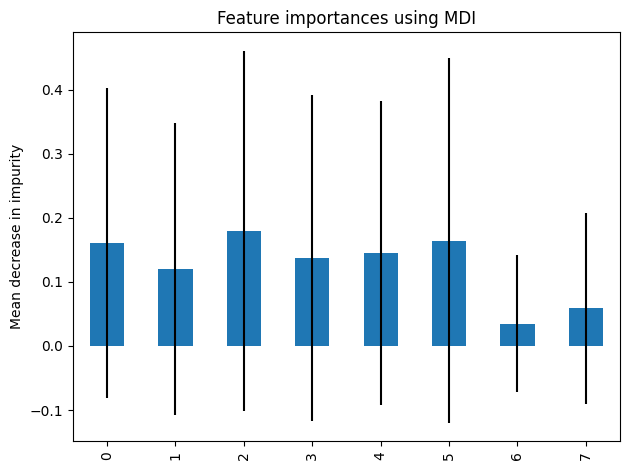

In [ ]:
model = RandomForestClassifier(n_estimators=100)



model.fit(X_train,y_train)



importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
print(model.feature_importances_)

In [ ]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train)

## Model Evaluation

### In-Sample Evaluation
<p align="Jutisfy"> We will be generating a classification report and a confusion matrix for the training data. It must be stressed that this is in-sample performance testing , which is the performance testing on the training dataset. These metrics are NOT truly indicative of the model's performance.</p>

In this section, we make predictions on the training set and store them in the <b><i>insample_ predictions</i></b> variable. A confusion matrix is generated to gauge the robustness of the model.

In [ ]:
insample_predictions = model.predict(X_train)

In [ ]:
insample_predictions = clf.predict(X_train)

In [ ]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

Insample Accuracy 100.00%
              precision    recall  f1-score   support

    Non Rice       1.00      1.00      1.00       150
        Rice       1.00      1.00      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



<p> For plotting a confusion matrix we define the function <b><i>plot_confusion_matrix</i></b>.

In [ ]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels');
    ax.set_title(title);
    ax.xaxis.set_ticklabels(labels);
    ax.yaxis.set_ticklabels(labels);

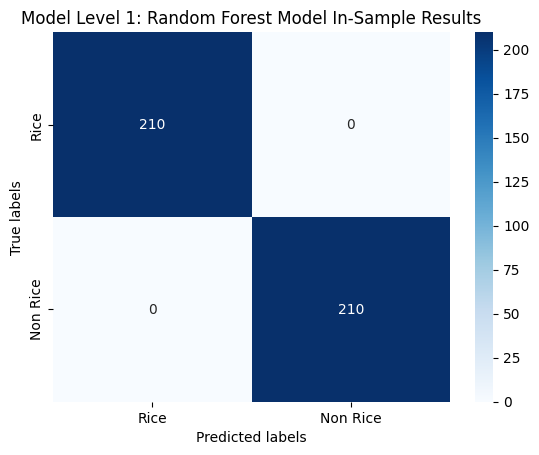

In [ ]:
plot_confusion_matrix(y_train,insample_predictions,"Model Level 1: Random Forest Model In-Sample Results",['Rice', 'Non Rice'])

### Out-Sample Evaluation

In [ ]:
outsample_predictions = model.predict(X_test)

In [ ]:
outsample_predictions = clf.predict(X_test)

In [ ]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))


Accuracy 100.00%
              precision    recall  f1-score   support

    Non Rice       1.00      1.00      1.00       150
        Rice       1.00      1.00      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



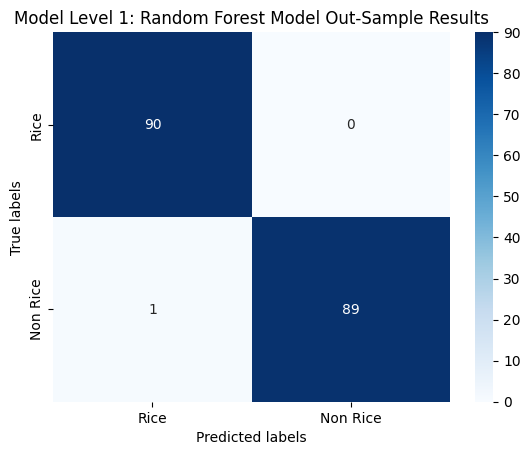

In [ ]:
plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: Random Forest Model Out-Sample Results",['Rice', 'Non Rice'])

## Submission

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving challenge_1_submission_template_correct_columns_fixed (1).csv to challenge_1_submission_template_correct_columns_fixed (1).csv


In [ ]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined
    dataset2 - Dataset 2 to be combined
    dataset3 - Dataset 3 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [ ]:
#Reading the coordinates for the submission
test_file = pd.read_csv('challenge_1_submission_template_correct_columns_fixed (1).csv')
test_file.head()

,id,target
0,"(10.18019073690894, 105.32022315786804)",NaN
1,"(10.561107033461816, 105.12772097986661)",NaN
2,"(10.623790611954897, 105.13771401411867)",NaN
3,"(10.583364246115156, 105.23946127195805)",NaN
4,"(10.20744446668854, 105.26844107128906)",NaN


In [ ]:
## Get Sentinel-1-RTC Data
time_slice = "2021-04-01/2021-04-10"
assests = ['vh','vv']
vh_vv_riv = []
for coordinates in tqdm(test_file['id']):
    vh_vv_riv.append(get_sentinel_data(coordinates,time_slice,assests))
vh_vv_rvi_data = pd.DataFrame(vh_vv_riv,columns =['vh','vv', 'rvi'])



100%|██████████| 250/250 [07:04<00:00,  1.70s/it]


In [ ]:
time_slice1 = "2021-01-01/2021-01-08"
assets1 = ['red','green', 'blue', 'nir']
mar_bands_set = []
for coordinates in tqdm(test_file['id']):
    mar_bands_set.append(get_sentinel2_data(coordinates,time_slice1,assets1))
S2_data = pd.DataFrame(mar_bands_set,columns =['red','green', 'blue', 'nir', 'NDVI', 'EVI', 'NDWI'])



100%|██████████| 250/250 [11:42<00:00,  2.81s/it]


In [ ]:
submission_vh_vv_data = combine_two_datasets(S2_data, vh_vv_rvi_data)


In [ ]:
submission_vh_vv_data = submission_vh_vv_data[['green', 'nir', 'NDVI', 'EVI', 'NDWI', 'vh', 'vv', 'rvi']]

In [ ]:
submission_vh_vv_data.head()

,green,nir,NDVI,EVI,NDWI,vh,vv,rvi
0,8365.986551,8603.422997,0.057047,-0.172192,-0.013992,0.022603,0.160415,0.462500
1,573.563681,622.993557,0.077552,-0.306942,-0.041310,0.023093,0.083714,0.765669
2,75.427244,79.778022,0.058583,-0.244422,-0.028032,0.040087,0.080690,1.085167
3,7823.494495,7174.462160,-0.005407,0.014318,0.043275,0.004060,0.015299,0.745714
4,8400.723738,8404.501226,0.045168,-0.127328,-0.000225,0.010877,0.082105,0.439688


In [ ]:
# Feature Scaling
scaled_submission_data = sc.transform(submission_vh_vv_data)


In [ ]:
#Making predictions
final_predictions = clf.predict(scaled_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [ ]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Latitude and Longitude':test_file['id'].values, 'Class of Land':final_prediction_series.values})

In [ ]:
#Displaying the sample submission dataframe
display(submission_df)

,Latitude and Longitude,Class of Land
0,"(10.18019073690894, 105.32022315786804)",Non Rice
1,"(10.561107033461816, 105.12772097986661)",Non Rice
2,"(10.623790611954897, 105.13771401411867)",Non Rice
3,"(10.583364246115156, 105.23946127195805)",Rice
4,"(10.20744446668854, 105.26844107128906)",Non Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Rice
247,"(10.581547330796518, 105.23991550078767)",Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [ ]:
#Dumping the predictions into a csv file.
submission_df.to_csv("rice_prediction_clf.csv",index = False)

In [ ]:
files.download('rice_prediction_clf.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>